<h1 style="text-align:center; text-decoration:underline">Nice to MET you</h1>
<p style="text-align:center"><b>More than 500 Italian paintings are now exhibited at Metropolitan Museum of Art, New York. What's the history behind their journeys?</b></p>
<hr>

<p style="text-align: justify"><b>Nice to MET you</b> is an Information Visualization project, exploring the Italian paintings that are exhibited at <b><em>The Metropolitan Museum of Art</em></b> in New York. More than five hundred Italian masterpieces are currently preserved at the MET, but how did they get there? The aim of this project is to examine the provenance of these artworks and those actors who contributed to the growth of this collection.</p>

<p style="text-align: justify">The project relies on two major sources, whose specific contribution will be clarified in the next section: The MET .csv Dataset (available at this <a href="https://media.githubusercontent.com/media/metmuseum/openaccess/master/MetObjects.csv">link</a>) and the <a href="http://data.fondazionezeri.unibo.it/">Zeri &amp; Lode RDF dataset</a>.</p>

<p style="text-align: justify">This Jupyter Notebook is intended to provide readers with a documentation of the project.</p> 

<h2 id="#anal">Data Analysis</h2>

<p style="text-align:justify">As part of the <b>Open Access Initiave</b>, <b><em>The Metropolitan Museum of Art</em></b> provides select datasets of information on more than 470,000 artworks. Among them, one can observe a considerable number of <b>Italian paintings</b>, an initial cataloguing of which was carried out by the Italian connoisseur <b>Federico Zeri</b> (1971-1986). The Metropolitan dataset contains many details about the creation and the accession of each artwork, along with cataloguing information and URI references to <b>Wikidata</b> and the Getty <b>Art &amp; Architecture Thesaurus</b>.</p>
<p style="text-align:justify">Nevertheless, some data about the provenance are still missing: this is the reason why, the present project exploits the information made available by the <b>Zeri &amp; Lode</b> project. The first release of the Zeri Photo Archive RDF dataset (April, 2016) represents a considerable subset of data already available at the <a href="http://catalogo.fondazionezeri.unibo.it/cerca/opera">Zeri Catalog web site</a>. Not all the Italian paintings preserved at the MET are currently represented in the RDF graph. However, the Zeri &amp; Lode project presents a major advantage: it allows users to better examine the history of the artworks. Each available transaction/transfer is in fact associated with its own URI, which is directly linked to the URIs of both the surrender and the receiver. In other words, the MET dataset only focuses on the last transfer of the artwork (column "Credit Line"; e.g.: <em>Bequest of Harry G. Sperling, 1971</em>), while the Zeri Catalog provides some more information also about the previous transactions (e.g.: <a href="http://data.fondazionezeri.unibo.it/id/artwork/16633/provenance-4" target="blank">http://data.fondazionezeri.unibo.it/id/artwork/16633/provenance-4</a>), allowing users to better track down some of the artworks' trajectories.</p>

<b style="font-size: 22px; text-decoration:underline">Step 1: Import Libraries</b>

In [1]:
#pandas
from pandas import read_sql
import pandas as pd

#sql 
from sqlite3 import connect

#sparql
from SPARQLWrapper import SPARQLWrapper, JSON
import sparql_dataframe

#regular expressions
import re

<b style="font-size: 22px; text-decoration:underline">Step 2: Extract Italian Paintaings from the general MET dataset</b>

<p>The MET dataset (<b>.csv</b> format) is converted into a <b>DataFrame</b>. The columns "Artist Nationality"/"Artist Display Bio" and "Department" allow us to isolate Italian Paintings creating a smaller DataFrame (<b><code>italianDataset</code></b>). This task is carried out through an <b>SQL</b> query.</p>

In [2]:
csvData = pd.read_csv("https://media.githubusercontent.com/media/metmuseum/openaccess/master/MetObjects.csv", encoding='utf-8')
with connect("metDB.db") as con:
    csvData.to_sql("MetCatalog", con, if_exists="replace", index=False)
    con.commit()
with connect("metDB.db") as con:
    query = """
        SELECT *
        FROM `MetCatalog`
        WHERE ("Artist Nationality" LIKE '%talian%' OR "Artist Display Bio" LIKE '%talian%') AND "Department" = "European Paintings";
    """
    italianDataset = pd.read_sql(query, con)
italianDataset.info()

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\sebas\anaconda3\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Object Number            532 non-null    object
 1   Is Highlight             532 non-null    int64 
 2   Is Timeline Work         532 non-null    int64 
 3   Is Public Domain         532 non-null    int64 
 4   Object ID                532 non-null    int64 
 5   Gallery Number           230 non-null    object
 6   Department               532 non-null    object
 7   AccessionYear            532 non-null    object
 8   Object Name              531 non-null    object
 9   Title                    532 non-null    object
 10  Culture                  0 non-null      object
 11  Period                   0 non-null      object
 12  Dynasty                  0 non-null      object
 13  Reign                    0 non-null      object
 14  Portfolio                0 non-null      o

<b style="font-size: 22px; text-decoration:underline">Step 3: Retrieve all the artworks currently preserved at the MET (Zeri Catalog)</b>

<p>The <b>Federico Zeri Catalog</b> deals with a huge collection of artworks: some of them are included in the MET dataset, but the Zeri Catalog offers a much more detailed presentation about the provenance of some paintings. In this case, we need to perform a <b>SPARQL</b> query: thus, we need an <b>endpoint</b> that allows us to reach the RDF dataset.</p>
<p>The CIDOC Conceptual Reference Model (<b>CIDOC-CRM</b>) was used to represent the richness of Zeri Photo Archive. Thus, <code><b>crm:</b></code> is the main PREFIX for this query.</p>
<p><a href="https://w3id.org/zericatalog/the-metropolitan-museum-of-art-new-york-ny">&lt;https://w3id.org/zericatalog/the-metropolitan-museum-of-art-new-york-ny&gt;</a> is the URIRef for the Metropolitan Museum.</p> 

In [3]:
endpoint = "http://data.fondazionezeri.unibo.it/sparql"

query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
SELECT DISTINCT ?artwork ?label_artwork ?inventory
WHERE {
  ?artwork crm:P50_has_current_keeper <https://w3id.org/zericatalog/the-metropolitan-museum-of-art-new-york-ny> .
  ?artwork  rdfs:label ?label_artwork.
  ?artwork crm:P55_has_current_location ?location .
  ?location  crm:P3_has_note ?inventory . 
  FILTER(LANG(?label_artwork) = "" || LANGMATCHES(LANG(?label_artwork), "en"))

}
"""

df = sparql_dataframe.get(endpoint, query, post=True)
df

,artwork,label_artwork,inventory
0,https://w3id.org/zericatalog/artwork/18789/item,"Artwork ""Luciani Sebastiano , Ritratto di Cris...",inv. 00.18.2
1,https://w3id.org/zericatalog/artwork/16633/item,"Artwork ""Del Conte Jacopino , Sacra Famiglia"" ...","inv. 1976.100.15, lascito Harry G. Sperling"
2,https://w3id.org/zericatalog/artwork/18917/item,"Artwork ""Anonimo sec. XVI , Ritratto di monaco...",inv. 1986.339.1
3,https://w3id.org/zericatalog/artwork/18008/item,"Artwork ""Rossi Francesco de' , Ritratto maschi...",inv. 45.128.11
4,https://w3id.org/zericatalog/artwork/18022/item,"Artwork ""Rossi Francesco de' , Ritratto maschi...",inv. 55.14
...,...,...,...
103,https://w3id.org/zericatalog/artwork/50670/item,"Artwork ""Bonvicino Alessandro , Ritratto di ge...",inv. 28.79
104,https://w3id.org/zericatalog/artwork/49125/item,"Artwork ""Tisi Benvenuto , San Nicola da Tolent...",inv. 17.190.24
105,https://w3id.org/zericatalog/artwork/49129/item,"Artwork ""Tisi Benvenuto , San Nicola da Tolent...",inv. 17.190.23
106,https://w3id.org/zericatalog/artwork/50819/item,"Artwork ""Bonvicino Alessandro , Deposizione di...",inv. 12.61


<b style="font-size: 22px; text-decoration:underline">Step 4: Retrieve all data about about each artwork's transfers (Zeri Catalog)</b>

<p>We are now interested in discovering something more about the artworks' provenance:</p>
<ul>
    <li>history: the number of the artwork's transfers recorded in the Zeri Dataset</li>
    <li>receivers: the adressees of the trasnfers</li>
    <li>surrenders: the surrenders of the artwork's custody</li>
</ul>

In [4]:
#Works' History - Federico Zeri Catalog

URI_string = ""

for index, row in df.iterrows():
    if len(URI_string) == 0:
        URI_string = "?artwork = <" + row["artwork"] + ">"
    else: 
        URI_string = URI_string + "||" + "?artwork = <" + row["artwork"] + ">"

final_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
SELECT ?artwork  (count(distinct ?tras) AS ?history) (group_concat(distinct ?label_receiver ; separator = "; ") AS ?receivers) (group_concat(distinct ?inventory ; separator = "; ") AS ?id) (group_concat(distinct ?label_surrender ; separator = "; ") AS ?surrenders)          
WHERE {{
  ?trasferimento_global crm:P30_transferred_custody_of ?artwork .
  ?tras crm:P30_transferred_custody_of ?artwork .
  OPTIONAL {{ ?trasferimento_global crm:P28_custody_surrendered_by ?surrender }} . 
  ?receiver crm:P29i_received_custody_through ?trasferimento_global .
  ?artwork crm:P50_has_current_keeper <https://w3id.org/zericatalog/the-metropolitan-museum-of-art-new-york-ny> .
  ?artwork crm:P55_has_current_location ?location .
  ?location  crm:P3_has_note ?inventory .
  FILTER ({0})
  
  ?artwork  rdfs:label ?label_artwork.
  ?surrender rdfs:label ?label_surrender.
  ?receiver rdfs:label ?label_receiver.
  FILTER(?receiver != <https://w3id.org/zericatalog/>)
  FILTER(?surrender != <https://w3id.org/zericatalog/>)
  
  FILTER(LANG(?label_artwork) = "" || LANGMATCHES(LANG(?label_artwork), "en"))
  FILTER(LANG(?label_surrender) = "" || LANGMATCHES(LANG(?label_surrender), "en"))
  FILTER(LANG(?label_receiver) = "" || LANGMATCHES(LANG(?label_receiver), "en"))
}} GROUP BY ?artwork
"""

final_df = sparql_dataframe.get(endpoint, final_query.format(URI_string), post=True)
final_df

,artwork,history,receivers,id,surrenders
0,https://w3id.org/zericatalog/artwork/39117/item,6,The Metropolitan Museum of Art; Collezione G. ...,inv. 1970.134.1,"Asta Sotheby's; Ashburnham Place, collezione A..."
1,https://w3id.org/zericatalog/artwork/39828/item,5,The Metropolitan Museum of Art; E. Sestieri; C...,inv. 48.17.12,E. Sestieri; Collezione Malanca; Collezione G....
2,https://w3id.org/zericatalog/artwork/39818/item,5,The Metropolitan Museum of Art; E. Sestieri; C...,inv. 48.17.5,E. Sestieri; Collezione Malanca; Collezione G....
3,https://w3id.org/zericatalog/artwork/45055/item,1,The Metropolitan Museum of Art,"inv. 14.40.650, dono B. Altman",Collezione B. Altman
4,https://w3id.org/zericatalog/artwork/39821/item,5,The Metropolitan Museum of Art; E. Sestieri; C...,inv. 48.17.7,E. Sestieri; Collezione Malanca; Collezione G....
5,https://w3id.org/zericatalog/artwork/39831/item,5,The Metropolitan Museum of Art; E. Sestieri; C...,inv. 48.17.14,E. Sestieri; Collezione Malanca; Collezione G....
6,https://w3id.org/zericatalog/artwork/16633/item,4,The Metropolitan Museum of Art; Collezione H.G...,"inv. 1976.100.15, lascito Harry G. Sperling",Collezione H.G. Sperling; Kleinberger Gallerie...
7,https://w3id.org/zericatalog/artwork/41423/item,2,The Metropolitan Museum of Art; Asta Christie's,inv. 1973.311.1,"Asta Christie's; Harewood House, collezione Ea..."
8,https://w3id.org/zericatalog/artwork/60085/item,1,The Metropolitan Museum of Art,inv. 1971.115.3b,"Duveen Brothers, Inc."
9,https://w3id.org/zericatalog/artwork/39841/item,5,The Metropolitan Museum of Art; E. Sestieri; C...,inv. 48.17.20,E. Sestieri; Collezione Malanca; Collezione G....


<b style="font-size: 22px; text-decoration:underline">Step 5: Merge multiple ids related to the same artwork</b>

<p style="text-align:justify">Our goal is to combine the two dataframes we have created so far (<code><b>italiaDataset</b></code> and <code><b>final_df</b></code>), thus, we need to align the artworks according to their Object Number (the only element shared by the two original Datasets). We then need to manipulate the column "id" (later renamed as "Object Number") of the <code><b>final_df</b></code>. First, the abbreviation "inv." at the beginning of each id must be removed, so that we can effectively compare the cataloguing number. Moreover, in the Zeri RDF dataset, multiple artworks related to the same group are considered as individual, while the MET dataset considers them as a single conceptual object. Therefore, it is necessary to group the artworks' ids from the Zeri dataset.</p>

In [5]:
a_list = []

for idx, row in final_df.iterrows():
    a_list.append(str(row["id"]).replace("inv. ", "").split(",")[0])
a_list
final_df["Object Number"] = a_list
final_df = final_df.drop(['id'], axis=1)


ser = final_df["Object Number"]
ser = ser.tolist()

id_dict = {}
a_list = []

for el in ser:
    w = str()
    for inn in el.split(".")[:-1]:
        if len(w) > 0:
            w = w + "." + inn
        else:
            w = w + inn
    if w not in id_dict:
        id_dict[w] = [el]
    else:
        a = id_dict[w]
        a.append(el)
        id_dict[w] = a

artwork_uris = []

number_rows = final_df.shape[0]

for el in id_dict["48.17"]:
    for idx, row in final_df.iterrows():
        if el == row["Object Number"]:
            history = row["history"]
            receivers = row["receivers"]
            surrenders = row["surrenders"]
            artwork_uris.append(row["artwork"])
            final_df = final_df.drop([idx])

final_df.loc[number_rows, :] = [(", ".join(artwork_uris)), history, receivers, surrenders, "48.17.1–22"]
number_rows = number_rows + 1

artwork_uris = []
for el in id_dict["1971.115"]:
    for idx, row in final_df.iterrows():
        if el == row["Object Number"]:
            history = row["history"]
            receivers = row["receivers"]
            surrenders = row["surrenders"]
            artwork_uris.append(row["artwork"])
            final_df = final_df.drop([idx])
            
final_df.loc[number_rows, :] = [(", ".join(artwork_uris)), history, receivers, surrenders, "1971.115.3ab"]
final_df

,artwork,history,receivers,surrenders,Object Number
0,https://w3id.org/zericatalog/artwork/39117/item,6.0,The Metropolitan Museum of Art; Collezione G. ...,"Asta Sotheby's; Ashburnham Place, collezione A...",1970.134.1
3,https://w3id.org/zericatalog/artwork/45055/item,1.0,The Metropolitan Museum of Art,Collezione B. Altman,14.40.650
6,https://w3id.org/zericatalog/artwork/16633/item,4.0,The Metropolitan Museum of Art; Collezione H.G...,Collezione H.G. Sperling; Kleinberger Gallerie...,1976.100.15
7,https://w3id.org/zericatalog/artwork/41423/item,2.0,The Metropolitan Museum of Art; Asta Christie's,"Asta Christie's; Harewood House, collezione Ea...",1973.311.1
10,https://w3id.org/zericatalog/artwork/32096/item,4.0,The Metropolitan Museum of Art; P. Corsini; Co...,P. Corsini; Collezione S. Brunswick; Hammer Ga...,1984.74
11,https://w3id.org/zericatalog/artwork/45062/item,4.0,The Metropolitan Museum of Art; Collezione J. ...,Collezione J. Pierpont Morgan; Collezioni real...,16.30ab
12,https://w3id.org/zericatalog/artwork/46494/item,1.0,The Metropolitan Museum of Art,Collezione G. e F. Blumenthal,41.100.12
13,https://w3id.org/zericatalog/artwork/18022/item,3.0,The Metropolitan Museum of Art; Collezione J.H...,Collezione J.H. Harding; Asta Christie's; Coll...,55.14
18,https://w3id.org/zericatalog/artwork/36357/item,3.0,The Metropolitan Museum of Art; Collezione T.M...,Collezione T.M. Davis; Collezione Baude; Colle...,30.95.270
21,https://w3id.org/zericatalog/artwork/45063/item,1.0,The Metropolitan Museum of Art,Convento di S. Antonio da Padova,32


<b style="font-size: 22px; text-decoration:underline">Step 6: Merge the Dataframes</b>

<p>We are now ready to merge our Dataframes (<code><b>italiaDataset</b></code> and <code><b>final_df</b></code>). In this way, the data from the two datasets (MET and Zeri Catalog) will be aligned in a unique Dataframe.</p>

In [6]:
#merging MET and Federico Zeri

from pandas import merge


result = pd.merge(final_df, italianDataset)
result.rename(columns={"Artist Alpha Sort":"ArtistAlphaSort"},inplace=True)
result.to_csv("data_management/result.csv")
result

,artwork,history,receivers,surrenders,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,https://w3id.org/zericatalog/artwork/39117/item,6.0,The Metropolitan Museum of Art; Collezione G. ...,"Asta Sotheby's; Ashburnham Place, collezione A...",1970.134.1,0,0,1,436567,None,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19911541,None,"Metropolitan Museum of Art, New York, NY",Infants|Women|Saint John the Baptist|Bedrooms|...,http://vocab.getty.edu/page/aat/300189561|http...,https://www.wikidata.org/wiki/Q998|https://www...
1,https://w3id.org/zericatalog/artwork/45055/item,1.0,The Metropolitan Museum of Art,Collezione B. Altman,14.40.650,0,1,1,437823,608.0,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19904807,None,"Metropolitan Museum of Art, New York, NY",Men|Portraits,http://vocab.getty.edu/page/aat/300025928|http...,https://www.wikidata.org/wiki/Q8441|https://ww...
2,https://w3id.org/zericatalog/artwork/16633/item,4.0,The Metropolitan Museum of Art; Collezione H.G...,Collezione H.G. Sperling; Kleinberger Gallerie...,1976.100.15,0,0,1,436770,None,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912153,None,"Metropolitan Museum of Art, New York, NY",Holy Family|Saint Joseph|Christ|Virgin Mary,http://vocab.getty.edu/page/ia/901001175|http:...,https://www.wikidata.org/wiki/Q618057|https://...
3,https://w3id.org/zericatalog/artwork/41423/item,2.0,The Metropolitan Museum of Art; Asta Christie's,"Asta Christie's; Harewood House, collezione Ea...",1973.311.1,0,1,1,435722,626.0,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19905185,None,"Metropolitan Museum of Art, New York, NY",Armor|Boys|Men|Portraits,http://vocab.getty.edu/page/aat/300226591|http...,https://www.wikidata.org/wiki/Q20793164|https:...
4,https://w3id.org/zericatalog/artwork/32096/item,4.0,The Metropolitan Museum of Art; P. Corsini; Co...,P. Corsini; Collezione S. Brunswick; Hammer Ga...,1984.74,0,1,1,437342,None,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19911628,None,"Metropolitan Museum of Art, New York, NY",Sadness|Suffering|Mary Magdalene|Saint John th...,http://vocab.getty.edu/page/aat/300055166|http...,https://www.wikidata.org/wiki/Q169251|https://...
5,https://w3id.org/zericatalog/artwork/45062/item,4.0,The Metropolitan Museum of Art; Collezione J. ...,Collezione J. Pierpont Morgan; Collezioni real...,16.30ab,1,1,1,437372,962.0,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q27033728,None,"Metropolitan Museum of Art, New York, NY",Madonna and Child|Saint Catherine|Saint John t...,http://vocab.getty.edu/page/ia/901000052| |htt...,https://www.wikidata.org/wiki/Q9309699| |https...
6,https://w3id.org/zericatalog/artwork/46494/item,1.0,The Metropolitan Museum of Art,Collezione G. e F. Blumenthal,41.100.12,0,1,1,437822,608.0,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19905075,None,"Metropolitan Museum of Art, New York, NY",Men|Portraits,http://vocab.getty.edu/page/aat/300025928|http...,https://www.wikidata.org/wiki/Q8441|https://ww...
7,https://w3id.org/zericatalog/artwork/18022/item,3.0,The Metropolitan Museum of Art; Collezione J.H...,Collezione J.H. Harding; Asta Christie's; Coll...,55.14,0,1,1,437598,None,...,None,Paintings,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912783,None,"Metropolitan Museum of Art, New York, NY",Men|Portraits,http://vocab.getty.edu/page/aat/300025928|http...,https://www.wikidata.org/wiki/Q8441|https://ww...
8,ht

<b style="font-size: 22px; text-decoration:underline">Step 7: retrieve further details about the entities involved in the artworks' cusotdy</b>

<p style="text-align:justify">The Zeri Dataset presents further details about some custody periods during which a certain artwork was kept by a specific entity. It is then possible to retrieve the time-span and the location of the custody through a SPARQL query. The last column of the new DataFrame ("location"), contains useful references to controlled knowledge bases/datasets.</p>

In [7]:
new_string = ""
for idx, row in result.iterrows():
    if idx == 0:
        if "," not in row["artwork"]:
            new_string = new_string + "strstarts(str(?custody), '" + row["artwork"].replace("/item", "/custody") + "')"
        else:
            artw = row["artwork"].split(",")[0]
            new_string = new_string + "strstarts(str(?custody), '" + artw.replace("/item", "/custody") + "')"
    else:
        if "," not in row["artwork"]:
            new_string = new_string + "|| strstarts(str(?custody), '" + row["artwork"].replace("/item", "/custody") + "')"
        else: 
            artw = row["artwork"].split(",")[0]
            new_string = new_string + "|| strstarts(str(?custody), '" + artw.replace("/item", "/custody") + "')"
access = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX ti: <http://www.ontologydesignpatterns.org/cp/owl/timeinterval.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
SELECT DISTINCT ?custody ?time_span ?start_date ?end_date ?place_label ?label_receiver ?location
WHERE {{
  ?receiver crm:P29i_received_custody_through ?custody .
  ?receiver crm:P74_has_current_or_former_residence ?place .
  ?custody crm:P4_has_time_span ?time_span .
  ?time_span ti:hasIntervalEndDate ?end_date .
  ?time_span ti:hasIntervalStartDate ?start_date .
  ?place owl:sameAs ?location .
  ?place rdfs:label ?place_label .
  ?receiver rdfs:label ?label_receiver .
  FILTER(LANG(?place_label) = "" || LANGMATCHES(LANG(?place_label), "en"))
  FILTER(LANG(?label_receiver) = "" || LANGMATCHES(LANG(?label_receiver), "en"))
  FILTER ({0})
}}
"""
third_df = sparql_dataframe.get(endpoint, access.format(new_string), post=True)   
third_df.to_csv("data_management/final.csv")

third_df

,custody,time_span,start_date,end_date,place_label,label_receiver,location
0,https://w3id.org/zericatalog/artwork/16633/cus...,https://w3id.org/zericatalog/date/1949-1958,1949-01-01T00:00:00Z,1958-01-01T00:00:00Z,Parigi,Collezione O. Wertheimer,http://sws.geonames.org/2988507
1,https://w3id.org/zericatalog/artwork/16633/cus...,https://w3id.org/zericatalog/date/1949-1958,1949-01-01T00:00:00Z,1958-01-01T00:00:00Z,Parigi,Collezione O. Wertheimer,http://www.wikidata.org/entity/Q90
2,https://w3id.org/zericatalog/artwork/16633/cus...,https://w3id.org/zericatalog/date/1949-1958,1949-01-01T00:00:00Z,1958-01-01T00:00:00Z,Parigi,Collezione O. Wertheimer,http://dbpedia.org/resource/Paris
3,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1934-1977,1934-01-01T00:00:00Z,1977-01-01T00:00:00Z,Parigi,Collezione Dillon,http://sws.geonames.org/2988507
4,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1934-1977,1934-01-01T00:00:00Z,1977-01-01T00:00:00Z,Parigi,Collezione Dillon,http://www.wikidata.org/entity/Q90
5,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1934-1977,1934-01-01T00:00:00Z,1977-01-01T00:00:00Z,Parigi,Collezione Dillon,http://dbpedia.org/resource/Paris
6,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1836-1934,1836-01-01T00:00:00Z,1934-01-01T00:00:00Z,Parigi,Collezione Chaix-d'Est Anges,http://sws.geonames.org/2988507
7,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1836-1934,1836-01-01T00:00:00Z,1934-01-01T00:00:00Z,Parigi,Collezione Chaix-d'Est Anges,http://www.wikidata.org/entity/Q90
8,https://w3id.org/zericatalog/artwork/16692/cus...,https://w3id.org/zericatalog/date/1836-1934,1836-01-01T00:00:00Z,1934-01-01T00:00:00Z,Parigi,Collezione Chaix-d'Est Anges,http://dbpedia.org/resource/Paris
9,https://w3id.org/zericatalog/artwork/33068/cus...,https://w3id.org/zericatalog/date/1925-1928,1925-01-01T00:00:00Z,1928-01-01T00:00:00Z,Londra,"Duveen Brothers, Inc.",https://w3id.org/zericatalog/place/london


<b style="font-size: 22px; text-decoration:underline">Step 8: split the Credit Line</b>

<p style="text-align:justify">As last step, we need to make available the content of the <b>Credit Line</b> column. All the information about how the MET acquired each artwork is included in this column. Though we have already extracted many details from the Zeri Catalog, we haven't focused yet on those artworks that are not included in the RDF Dataset. Consequently, we would like to retrieve as many data as possible from the MET Dataset.</p>
<p style="text-align:justify">In particular, we are interested in two major aspects: how the MET acquired/received the custody of the artwork (Purchase, Bequest, Collection, Gift are the possible labels for <b>"last Transfer"</b>) and the entities involved in this last transition (<b>"agentsTransfer"</b>). Unfortunately, no detail is available about previous transfers.</p>

In [8]:
empty = pd.Series([""])
resp = pd.Series([""])

def add_last_transfer(num, obj):
    italianDataset.at[num, "lastTransfer"] = obj

def add_agent(num, agent):
    if agent.startswith("and "):
        agent = agent.replace("and ", "")
    if agent.endswith(" "):
        agent = agent[:-1]
    if type(italianDataset.at[num, "agentsTransfer"]) == type("") and len(italianDataset.at[num, "agentsTransfer"]) > 0:
        if agent not in italianDataset.at[num, "agentsTransfer"].split(", ") and (agent + " Fund") not in italianDataset.at[num, "agentsTransfer"].split(", "):
            italianDataset.at[num, "agentsTransfer"] = italianDataset.at[num, "agentsTransfer"] + ", " + agent
        else:
            return None
    else:
        italianDataset.at[num, "agentsTransfer"] = agent

def and_case(a_string, credit):
    if " and " in credit and "Mr" not in credit and "Mrs." not in credit and "Foundation" not in credit and "Fund" not in credit and "Collection" not in credit and "Gallery" not in credit and "Charitable" not in credit:
        x = modified_credit.replace(a_string, "").split(" and ")
        if " " in x[0] and " " in x[0]:
            f = x[0]
            s = x[1]
            add_agent(idx, f)
            add_agent(idx, s)
        else: 
            add_agent(idx, modified_credit.replace(a_string, ""))
    else:
        add_agent(idx, modified_credit.replace(a_string, ""))

    


a = 0
while a < 2:
    for idx, row in italianDataset.iterrows():
        if row["Credit Line"].count(";") > 1:
            italianDataset.at[idx, "Credit Line"]=row["Credit Line"].replace(";", ",")
        if row["Credit Line"].startswith("The Metropolitan Museum of Art, New York."):
            italianDataset.at[idx, "Credit Line"] = row["Credit Line"].replace("The Metropolitan Museum of Art, New York. ", "")
        if ":" in row["Credit Line"]:
            x = row["Credit Line"]
            x = x.replace(":",  ",")
            italianDataset.at[idx, "Credit Line"] = x
        if ", by exchange," in row["Credit Line"]:
            italianDataset.at[idx, "Credit Line"] = row["Credit Line"].replace(", by exchange",  "")
    a = a + 1
italianDataset["lastTransfer"] = empty
italianDataset["agentsTransfer"] = resp
for idx, row in italianDataset.iterrows():        
    if ";" not in row["Credit Line"]:
        credit_line = row["Credit Line"].split(", ")
        modified_credit = credit_line[0]
        if modified_credit == "Anonymous Gift" and len(credit_line) == 2 or row["Credit Line"].startswith("Anonymous Gift, in memory"):
            add_last_transfer(idx, "Gift")
        if modified_credit.startswith("Bequest of "):
            add_last_transfer(idx, "Bequest")
            if " in honor of" in modified_credit:
                modified_credit = modified_credit.split(" in honor of")[0]
            and_case("Bequest of ", modified_credit)
        elif modified_credit.startswith("The Bequest of "):
            add_last_transfer(idx, "Bequest")
            and_case("The Bequest of ", modified_credit)
        elif modified_credit.startswith("The Collection of ") or modified_credit.startswith("From the Collection of "):
            if modified_credit.startswith("From the Collection of "):
                modified_credit = modified_credit.replace ("From ", "")
            add_agent(idx, modified_credit)
            add_last_transfer(idx, "Collection")
        elif modified_credit.startswith("Gift of "):
            add_last_transfer(idx, "Gift")
            and_case("Gift of ", modified_credit)
            for n in range(len(credit_line)-2):
                n = n + 1
                if "Purchase" not in credit_line[n] and "Collection" not in credit_line[n] and "Bequest" not in credit_line[n] and "Fund" not in credit_line[n] and "Gift" not in credit_line[n] and "memory" not in credit_line[n] and "in honor" not in credit_line[n] and "in celebration" not in credit_line[n]:
                    if "in memory of h" not in credit_line[n-1] and "in honor" not in credit_line[n-1]:
                        add_agent(idx, credit_line[n].replace("and ", "", 1))
        elif modified_credit.startswith("Purchase"):
            add_last_transfer(idx, "Purchase")
        elif modified_credit.endswith("Collection") or modified_credit.endswith("Gallery"):
            add_agent(idx, modified_credit)
            add_last_transfer(idx, "Collection")
        elif modified_credit.endswith("Fund") or modified_credit.endswith("Trust"):
            add_agent(idx, modified_credit)
            add_last_transfer(idx, "Purchase")
        elif modified_credit.endswith("Funds") and " and " in modified_credit:
            add_last_transfer(idx, "Purchase")
            for el in modified_credit.split(" and "):
                add_agent(idx, (el + " Fund"). replace(" Funds", ""))
        elif "Funds" in row["Credit Line"] and "Bequest" not in row["Credit Line"] and "Purchase" not in row["Credit Line"] and "Gift" not in row["Credit Line"] and "funds from various donors" not in row["Credit Line"]:
            add_last_transfer(idx, "Purchase")
            split = row["Credit Line"].split(",")
            if len(split) > 2:
                for n in range(len(split)-1):
                    a = split[n].replace(" Funds", "") + " Fund"
                    if a.startswith(" and"):
                        a =a.replace(" and ", "")
                    elif a.startswith(" "):
                        a =a.replace (" ", "", 1)
                    add_agent(idx, a)
            else:
                if split[0] == "Funds from various donors":
                    italianDataset.at[idx, "agentsTransfer"] = italianDataset.at[idx, "agentsTransfer"]
                else:
                    new_split = split[0].split(" and ")
                    for n in range(len(new_split)):
                        a = new_split[n].replace(" Funds", "") + " Fund"
                        add_agent(idx, a)       
        if len(credit_line) > 2:
            for n in range(len(credit_line)-2):
                num = n + 1
                if credit_line[num] and "in memory " not in credit_line[num]:
                    new_modified_credit = credit_line[num]
                    if new_modified_credit.startswith("Bequest and Gift"):
                        add_agent(idx, new_modified_credit.replace("Bequest and Gift of ", ""))
                    if new_modified_credit.startswith("Bequest of"):
                        if " and " in new_modified_credit and "Mr" not in new_modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit:
                            if " and Gift " in new_modified_credit:
                                x = new_modified_credit.replace("Bequest of ", "").split(" and Gift of ")
                                add_agent(idx, x[0])
                                add_agent(idx, x[1])
                            else:
                                x = new_modified_credit.replace("Bequest of ", "").split(" and ")
                                if " " in x[0] and " " in x[0]:
                                    f = x[0]
                                    s = x[1]
                                    add_agent(idx, f)
                                    add_agent(idx, s)
                                else: 
                                    add_agent(idx, new_modified_credit.replace(" Bequest of ", ""))
                        else:
                            add_agent(idx, new_modified_credit.replace("Bequest of ", ""))
                    if new_modified_credit.startswith("Bequests of"):
                        if " and " in new_modified_credit and "Mr" not in new_modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit:
                            x = new_modified_credit.replace("Bequests of ", "").split(" and ")
                            if " " in x[0] and " " in x[0]:
                                f = x[0]
                                s = x[1]
                                add_agent(idx, f)
                                add_agent(idx, s) 
                            else: 
                                add_agent(idx, new_modified_credit.replace("Bequest of ", ""))
                        else:
                            add_agent(idx, new_modified_credit.replace("Bequests of ", ""))
                        new_n = num + 1
                        while new_n != 0:
                            if not credit_line[new_n].startswith("1") and "Bequest" not in credit_line[new_n] and "Gift" not in credit_line[new_n] and "Purchase" not in credit_line[new_n] and "Fund" not in credit_line[new_n] and "Collection" not in credit_line[new_n]:
                                if "in memory " not in credit_line[new_n] and "in memory of h" not in credit_line[new_n-1]:
                                    add_agent(idx, credit_line[new_n])
                                new_n = new_n + 1
                            else:
                                new_n = 0
                    if new_modified_credit.startswith("and Gifts of"):
                        if " and " in new_modified_credit:
                            x = new_modified_credit.split(" and ")
                            for el in x:
                                add_agent(idx, el.replace("and Gifts of ", ""))
                    if new_modified_credit.startswith("and Bequests of"):
                        if " and " in new_modified_credit and "Mr" not in new_modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit:
                            x = new_modified_credit.replace("and Bequests of ", "").split(" and ")
                            if " " in x[0] and " " in x[0]:
                                f = x[0]
                                s = x[1]
                                add_agent(idx, f)
                                add_agent(idx, s) 
                            else: 
                                add_agent(idx, new_modified_credit.replace(" Bequest of ", ""))
                        else:
                            add_agent(idx, new_modified_credit.replace("and Bequests of ", ""))
                    if new_modified_credit.startswith("and Bequest of"):
                        add_agent(idx, new_modified_credit.replace("and Bequest of ", ""))
                    if new_modified_credit.startswith("Gift of"):
                        if " and " in new_modified_credit and "Mr" not in modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit and "and Bequest" not in new_modified_credit:
                            x = new_modified_credit.replace("Gift of ", "").split(" and ")
                            if " " in x[0] and " " in x[0]:
                                f = x[0]
                                s = x[1]
                                add_agent(idx, f)
                                add_agent(idx, s) 
                            else: 
                                add_agent(idx, new_modified_credit.replace(" Gift of ", ""))
                        elif " and Bequest of " in new_modified_credit:
                            if new_modified_credit.startswith("Gift and"):
                                new_modified_credit = new_modified_credit.replace("Gift", "")
                            x = new_modified_credit.split(" and Bequest of ")
                            for el in x:
                                add_agent(idx, el.replace("Gift of ", ""))
                        else:
                            add_agent(idx, new_modified_credit.replace("Gift of ", ""))
                    if new_modified_credit.startswith("and Gift "):
                        add_agent(idx, new_modified_credit.replace("and Gift of ", ""))
                    if new_modified_credit.endswith("Gift"):
                        if " and " in new_modified_credit and "Mr" not in modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit and "and Bequest" not in new_modified_credit:
                            x = new_modified_credit.replace("Gift", "").split(" and ")
                            if " " in x[0] and " " in x[0]:
                                f = x[0]
                                s = x[1]
                                add_agent(idx, f)
                                add_agent(idx, s) 
                            else: 
                                if new_modified_credit.replace("Gift", "").startswith(" and"):
                                    add_agent(idx, new_modified_credit.replace("Gift", "").replace("and ", ""))
                                else:
                                    add_agent(idx, new_modified_credit.replace("Gift", ""))
                        elif "Fund" in new_modified_credit and " and " in new_modified_credit:
                            x = new_modified_credit.split(" and ")
                            for el in x:
                                add_agent(idx, el.replace(" Gift", "")) 
                        else:
                            a = new_modified_credit.replace(" Gift", "")
                            if a.startswith("and "):                       
                                a=a.replace("and ", "", 1)
                            add_agent(idx, a)
                    if new_modified_credit.endswith("Bequest"):
                        if " and " in new_modified_credit and "Mr" not in modified_credit and "Mrs." not in new_modified_credit and "Foundation" not in new_modified_credit and "Fund" not in new_modified_credit and "Collection" not in new_modified_credit and "Gallery" not in new_modified_credit and "Charitable" not in new_modified_credit and "and Bequest" not in new_modified_credit:
                            x = new_modified_credit.replace("Bequest", "").split(" and ")
                            if " " in x[0] and " " in x[0]:
                                f = x[0]
                                s = x[1]
                                add_agent(idx, f)
                                add_agent(idx, s) 
                            else: 
                                add_agent(idx, new_modified_credit.replace("Gift", ""))
                        else:
                            add_agent(idx, new_modified_credit.replace("Bequest", ""))
                    if new_modified_credit.endswith("Fund"):
                        if "Gift" in new_modified_credit and " and " in new_modified_credit and "and Bequest of" not in new_modified_credit:
                            x = new_modified_credit.split(" and ")
                            for el in x:
                                add_agent(idx, el.replace(" Gift", "")) 
                        elif "Gift and Bequest of" in new_modified_credit:
                            x = new_modified_credit.replace("Gift and Bequest of ", "").split(" and ")
                            for el in x:
                                add_agent(idx, el)
                        else:
                            add_agent(idx, new_modified_credit)
                    if new_modified_credit.endswith("Funds"):
                        y = num
                        if "Purchase" not in credit_line[y-1] and "Gift" not in credit_line[y-1] and "Bequest" not in credit_line[y-1] and "Collection" not in credit_line[y-1]:
                            add_agent(idx, new_modified_credit.replace(" Funds", " Fund").replace("and ", "", 1))
                            
                            while y > 1:
                                y = y - 1
                                if "Purchase" not in credit_line[y] and "Gift" not in credit_line[y] and "Bequest" not in credit_line[y] and "Collection" not in credit_line[y] and "in memory" not in credit_line[y]:
                                    if credit_line[y].startswith("and "):
                                        add_agent(idx, (credit_line[y] + " Fund").replace("and ", "", 1))
                                    else:
                                        add_agent(idx, (credit_line[y] + " Fund"))
                                else:
                                    y = 0
                        else:
                            if " and " in new_modified_credit:
                                for el in new_modified_credit.split(" and "):
                                    add_agent(idx, (el.replace(" Funds", "") + " Fund"))
                    if new_modified_credit.endswith(" Gifts"):
                        
                        if new_modified_credit.count(" and ") > 1 and not new_modified_credit.startswith(" and "):
                            x = new_modified_credit.split(" and ")
                            for n in range(len(x)-1):
                                num = n + 1
                                if " " not in x[num-1] and " " in x[num]:
                                    f = x[num-1] + " and " + x[num]
                                    add_agent(idx, f.replace(" Gifts", ""))
                                else:
                                    add_agent(idx, x[num].replace(" Gifts", ""))
                        elif "Foundation" in new_modified_credit and " and " in new_modified_credit:
                            x = new_modified_credit.split(" and ")
                            for el in x:
                                add_agent(idx, el.replace(" Gifts", ""))
                        else:
                            y = num
                            if new_modified_credit.startswith("and "):
                                new_modified_credit = new_modified_credit.replace("and ", "", 1)
                            add_agent(idx, new_modified_credit.replace(" Gifts", ""))
                            while y > 1:
                                y = y - 1
                                if "Purchase" not in credit_line[y] and "Gift" not in credit_line[y] and "Bequest" not in credit_line[y] and "Collection" not in credit_line[y]:
                                    add_agent(idx, credit_line[y])
                                else: 
                                    y = 0
                                
    elif row["Credit Line"].count(";") == 1:
        credit_line_update = row["Credit Line"].split(";")
        credit_line_segment_one = credit_line_update[0].split(",")
        if credit_line_segment_one[0].startswith("Gift of"):
            add_last_transfer(idx, "Gift")
            if " and " in credit_line_segment_one[0] and "Mr" not in credit_line_segment_one[0] and "Mrs." not in credit_line_segment_one[0] and "Foundation" not in credit_line_segment_one[0] and "Fund" not in credit_line_segment_one[0] and "Collection" not in credit_line_segment_one[0] and "Gallery" not in credit_line_segment_one[0] and "Charitable" not in credit_line_segment_one[0]:
                x = credit_line_segment_one[0].replace("Gift of ", "").split(" and ")
                if " " in x[0] and " " in x[0]:
                    f = x[0]
                    s = x[1]
                    add_agent(idx, f)
                    add_agent(idx, s) 
                else: 
                    add_agent(idx, credit_line_segment_one[0].replace("Gift of ", ""))
            else:
                add_agent(idx, credit_line_segment_one[0].replace("Gift of ", ""))
        if credit_line_segment_one[0].startswith("Purchase"):
            add_last_transfer(idx, "Purchase")
        if credit_line_segment_one[-1].endswith("Gifts"):

            for n in range(len(credit_line_segment_one) - 1):
                num = n + 1
                if "Collection" in credit_line_segment_one[num] or "Fund" in credit_line_segment_one[num] or "Foundation" in credit_line_segment_one[num]:
                    add_agent(idx, credit_line_segment_one[num].replace(" ", "", 1))
                else:
                    if credit_line_segment_one[num].startswith(" and"):
                        credit_line_segment_one[num] = credit_line_segment_one[num].replace(" and", "")
                    add_agent(idx, credit_line_segment_one[num].replace(" ", "", 1).replace(" Gifts", ""))
        credit_line_segment_two = credit_line_update[1].split(",")
        if credit_line_segment_two[0].startswith(" and Gifts"): 
            for n in range(len(credit_line_segment_two) - 1):
                num = n
                if "Bequest" not in credit_line_segment_two[num] and "Collection" not in credit_line_segment_two[num] and "Fund" not in credit_line_segment_two[num] and "by exchange" not in credit_line_segment_two[num]:
                    if "Mr. and Mrs." in credit_line_segment_two[num]:
                        add_agent(idx, credit_line_segment_two[num].replace(" and Gifts of","").replace(" ", "", 1))
                    else:
                        add_agent(idx, credit_line_segment_two[num].replace(" and Gifts of","").replace(" and ", " ", 1).replace(" ", "", 1))
                elif "Collection" in credit_line_segment_two[num] or "Fund" in credit_line_segment_two[num]:
                    add_agent(idx, credit_line_segment_two[num].replace(" and","").replace(" ", "", 1))
                elif "Bequest" in credit_line_segment_two[num]:
                    if credit_line_segment_two[num].startswith(" Bequests of"):
                        inner_list = credit_line_segment_two[num].split(" and")
                        for el in inner_list:
                            add_agent(idx, el.replace(" Bequests of","").replace(" ", "", 1))
        for el in credit_line_segment_two:
            if "Collection" in el:
                add_agent(idx, el.replace(" ", "", 1))

#private collections are often related to the bequest of a private owner, we thus need to associated both the collection and the owner with a unique entity 
for idx, row in italianDataset.iterrows():    
    dealer = row["agentsTransfer"]
    if "Collection," in str(dealer):
        dealerList = str(dealer).split(", ")
        italianDataset.at[idx, "agentsTransfer"] = dealerList[1]


italianDataset.to_csv("data_management/transfers.csv")

italianDataset

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,...,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL,lastTransfer,agentsTransfer
0,1985.5,0,0,1,435573,None,European Paintings,1985.0,Painting,Flora and Zephyr,...,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912099,None,"Metropolitan Museum of Art, New York, NY",Goddess|Putti|Flowers|Landscapes,http://vocab.getty.edu/page/aat/300343852|http...,https://www.wikidata.org/wiki/Q205985|https://...,Purchase,Rudolph and Lentilhon G. von Fluegge Foundatio...
1,12.6,0,0,1,435574,None,European Paintings,1912.0,"Painting, predella panel",The Crucifixion,...,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19905919,None,"Metropolitan Museum of Art, New York, NY",Soldiers|Men|Crucifixion|Horses|Mountains|Ange...,http://vocab.getty.edu/page/aat/300185678|http...,https://www.wikidata.org/wiki/Q4991371|https:/...,Purchase,Rogers Fund
2,42.53.2,0,0,1,435575,None,European Paintings,1942.0,"Painting, miniature","Jérôme Bonaparte (1784–1860), King of Westphalia",...,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19913805,None,"Metropolitan Museum of Art, New York, NY",Kings|Men|Portraits,http://vocab.getty.edu/page/aat/300025481|http...,https://www.wikidata.org/wiki/Q12097|https://w...,Gift,Helen O. Brice
3,1991.27.2,0,1,1,435576,624.0,European Paintings,1991.0,Painting,Saint Alexander,...,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912513,None,"Metropolitan Museum of Art, New York, NY",Bishops|Croziers|Miter,http://vocab.getty.edu/page/aat/300025756|http...,https://www.wikidata.org/wiki/Q29182|https://w...,Bequest,Lucy G. Moses
4,14.40.628,0,1,1,435577,None,European Paintings,1914.0,Painting,The Crucifixion,...,None,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19905200,None,"Metropolitan Museum of Art, New York, NY",Crucifixion|Saints|Mary Magdalene|Saint Franci...,http://vocab.getty.edu/page/aat/300404300|http...,https://www.wikidata.org/wiki/Q3235597|https:/...,Bequest,Benjamin Altman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2020.263.5,0,0,1,816624,627.0,European Paintings,2020.0,Painting,Basket of Fruit,...,None,http://www.metmuseum.org/art/collection/search...,None,None,"Metropolitan Museum of Art, New York, NY",Grapes|Fruit|Still Life|Apples|Pomegranates,http://vocab.getty.edu/page/aat/300379338|http...,https://www.wikidata.org/wiki/Q10978|https://w...,Bequest,Errol M. Rudman
528,2020.263.8,0,0,1,816629,623.0,European Paintings,2020.0,Painting,The Flight into Egypt,...,None,http://www.metmuseum.org/art/collection/search...,None,None,"Metropolitan Museum of Art, New York, NY",None,None,None,Bequest,Errol M. Rudman
529,2020.263.6,0,0,1,816630,None,European Paintings,2020.0,Painting,Charity,...,None,http://www.metmuseum.org/art/collection/search...,None,None,"Metropolitan Museum of Art, New York, NY",Nursing|Sleeping|Female Nudes|Infants,http://vocab.getty.edu/page/aat/300379905|http...,https://www.wikidata.org/wiki/Q174876|https://...,Bequest,Errol M. Rudman
530,2020.112,0,0,0,817124,618.0,European Paintings,2020.0,Painting,Cain Slaying Abel,...,None,http://www.metmuseum.org/art/collection/search...,None,None,"Metropolitan Museum of Art, New York, NY",Abel|Cain,http://vocab.getty.edu/page/ia/901000498|http:...,https://www.wikidata.org/wiki/Q313421|https://...,Gift,Alan M. May


<h2 align=center>InfoViz MET Data with Python (Part 0)</h2>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# read in the graph
# G = pickle.load(open('major_us_cities', 'rb'))
H = nx.DiGraph()


In [2]:
csvData = pd.read_csv("draftIntegrated.csv")
csvDataRefined = csvData.drop([0,15,23], axis=0)

In [3]:
for i, row in csvDataRefined.iterrows():
    arcs = []
    listInst = row["receivers"].split(",")
    for idx, el in enumerate(listInst):
        if idx < len(listInst)-1:
            transfer = (el,listInst[idx+1])
            arcs.append(transfer)
        else:
            arcs.append((el, row["surrenders"].split(",")[-1]))
    H.add_edges_from(arcs)

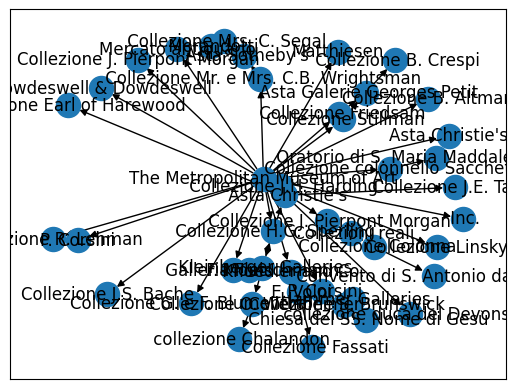

In [4]:
nx.write_gexf(H, "metzeri.gexf")
nx.draw_networkx(H)
plt.show()

In [5]:
# plt.figure(figsize=(10,9))
# nx.draw_networkx(H)

In [6]:
# draw the graph using the default spring layout
# plt.figure(figsize=(10,9))
# nx.draw_networkx(H)

In [7]:
# See what layouts are available in networkX
[x for x in nx.__dir__() if x.endswith('_layout')]

['bipartite_layout',
 'circular_layout',
 'kamada_kawai_layout',
 'random_layout',
 'rescale_layout',
 'shell_layout',
 'spring_layout',
 'spectral_layout',
 'planar_layout',
 'fruchterman_reingold_layout',
 'spiral_layout',
 'multipartite_layout',
 'arf_layout']

In [8]:
# Draw the graph using the random layout
# plt.figure(figsize=(10,9))
# pos = nx.random_layout(H)
# nx.draw_networkx(H, pos)

In [9]:
# Draw the graph using the circular layout
# plt.figure(figsize=(10,9))
# pos = nx.circular_layout(H)
# nx.draw_networkx(H, pos)

In [10]:
# Draw the graph using custom node positions
# plt.figure(figsize=(10,7))

# pos = nx.get_node_attributes(H)
# nx.draw_networkx(H, pos)

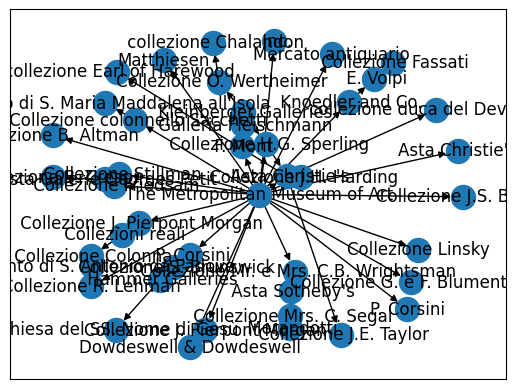

In [12]:
pos=nx.draw_networkx(H)


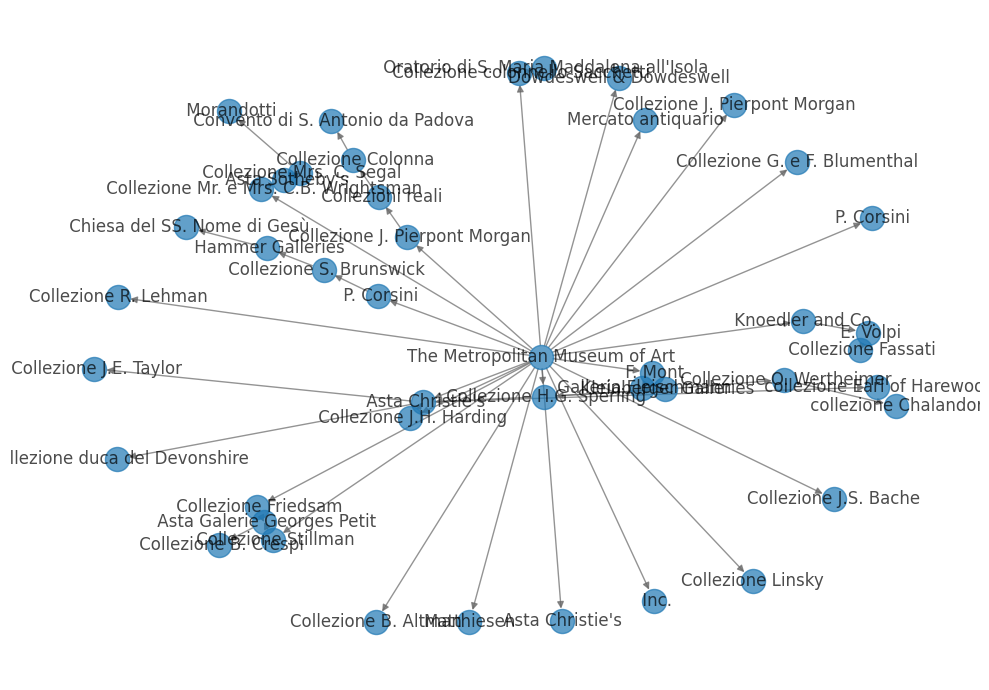

In [14]:
# Draw the graph adding alpha, removing labels, and softening edge color
plt.figure(figsize=(10,7))

nx.draw_networkx(H, pos, alpha=0.7, with_labels=True, edge_color='.4')

plt.axis('off')
plt.tight_layout();

In [1]:
# # Draw graph with varying node color, node size, and edge width
# plt.figure(figsize=(10,7))
#
# node_color = [H.degree(v) for v in H]
# node_size = 300#[0.0005*nx.get_node_attributes(H, 'population')[v] for v in H]
# edge_width = [0.0015*H[u][v]['surrenders'] for u,v in H.edges()]
#
# nx.draw_networkx(H, pos, node_size=node_size,
#                  node_color=node_color, alpha=0.7, with_labels=False,
#                  width=edge_width, edge_color='.4', cmap=plt.cm.Blues)
#
# nx.draw_networkx_labels(H, pos, labels={'The Metropolitan Museum of Art': 'MET'}, font_size=18, font_color='w')
#
# plt.axis('off')
# plt.tight_layout();

In [31]:
# # Draw graph with varying node color, node size, and edge width
# plt.figure(figsize=(10,7))

# node_color = [H.degree(v) for v in H]
# node_size = [0.0005*nx.get_node_attributes(H, 'The Metropolitan Museum of Art')[v] for v in H]
# # edge_width = [0.0015*G[u][v]['weight'] for u,v in G.edges()]

# nx.draw_networkx(H, pos, node_size=node_size,
#                  node_color=node_color, alpha=0.7, with_labels=False,
#                  width=4, edge_color='.4', cmap=plt.cm.Blues)

# plt.axis('off')
# plt.tight_layout();

In [17]:
# Draw specific edges and add labels to specific nodes
# plt.figure(figsize=(10,7))

# node_color = [G.degree(v) for v in G]
# node_size = [0.0005*nx.get_node_attributes(G, 'population')[v] for v in G]
# edge_width = [0.0015*G[u][v]['weight'] for u,v in G.edges()]

# nx.draw_networkx(G, pos, node_size=node_size,
#                  node_color=node_color, alpha=0.7, with_labels=False,
#                  width=edge_width, edge_color='.4', cmap=plt.cm.Blues)


# greater_than_770 = [x for x in G.edges(data=True) if x[2]['weight']>770]
# nx.draw_networkx_edges(G, pos, edgelist=greater_than_770, edge_color='r', alpha=0.4, width=6)

# nx.draw_networkx_labels(G, pos, labels={'Los Angeles, CA': 'LA', 'New York, NY': 'NYC'}, font_size=18, font_color='w')

# plt.axis('off')
# plt.tight_layout();

In [4]:
# print(H)

In [2]:
# df_g = nx.to_pandas_edgelist(H)
# df_g

In [3]:
# print(H.edges)


In [39]:
# import csv
# from tqdm import tqdm


In [40]:

# I = nx.DiGraph()

In [5]:
# with open('draftIntegrated.csv', 'r') as f:
#     data = csv.reader(f)
#     headers = next(data)
#     for row in tqdm(data):
#         I.add_node(row[3]) #superhero in first column
#         I.add_node(row[5]) #superhero in second column
#         if I.has_edge(row[3], row[5]):
#             # edge already exists, increase weight by one
#             I[row[3]][row[5]]['weight'] += 1
#         else:
#             # add new edge with weight 1
#             I.add_edge(row[3], row[5], weight = 1)


In [ ]:
# I_nodes = I.number_of_nodes()
# I_edges = I.number_of_edges()
# print("Nodes = ", I_nodes, " Edges = ",I_edges)

In [ ]:
# nx.draw_networkx(I)
# plt.show()

In [ ]:
# df_I = nx.to_pandas_edgelist(I)
# df_I

<h2 align=center>InfoViz MET Data with Seaborn and Python (Part 1)</h2>

### Libraries

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', None)
pd.options.display.width = 0
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task 1: Data Loading and Exploration

In [2]:
#ita_data=pd.read_csv('italianData.csv')
ita_data=pd.read_csv("E:\\GitHub\\infoviz\\data_management\\transfers.csv")
ita_data.head(3)

,Unnamed: 0.1,Unnamed: 0,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,...,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL,lastTransfer,agentsTransfer,lastDealer
0,0,0,1985.5,0,0,1,435573,NaN,European Paintings,1985.0,...,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19912099,NaN,"Metropolitan Museum of Art, New York, NY",Goddess|Putti|Flowers|Landscapes,http://vocab.getty.edu/page/aat/300343852|http...,https://www.wikidata.org/wiki/Q205985|https://...,Purchase,Rudolph and Lentilhon G. von Fluegge Foundatio...,Rudolph and Lentilhon G. von Fluegge Foundatio...
1,1,1,12.6,0,0,1,435574,NaN,European Paintings,1912.0,...,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19905919,NaN,"Metropolitan Museum of Art, New York, NY",Soldiers|Men|Crucifixion|Horses|Mountains|Ange...,http://vocab.getty.edu/page/aat/300185678|http...,https://www.wikidata.org/wiki/Q4991371|https:/...,Purchase,Rogers Fund,Rogers Fund
2,2,2,42.53.2,0,0,1,435575,NaN,European Paintings,1942.0,...,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q19913805,NaN,"Metropolitan Museum of Art, New York, NY",Kings|Men|Portraits,http://vocab.getty.edu/page/aat/300025481|http...,https://www.wikidata.org/wiki/Q12097|https://w...,Gift,Helen O. Brice,Helen O. Brice


### Task 2: Visualizing the Target Distribution

C:\Users\aligh\AppData\Local\Temp\ipykernel_22204\232986369.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

E:\DHDK\datascience-in-dataspell\datascience-in-dataspell\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



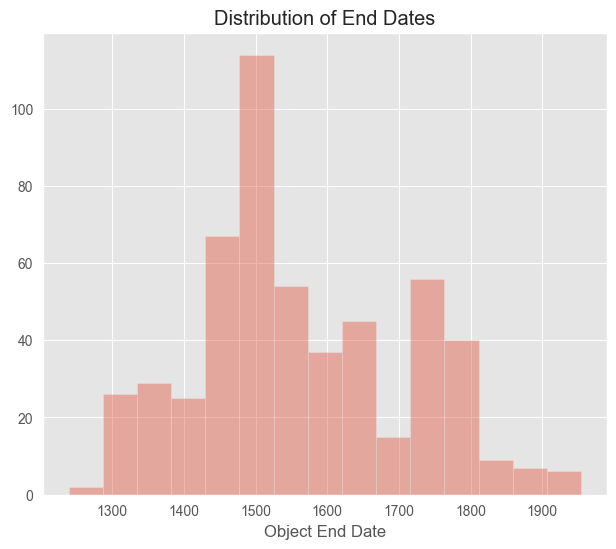

In [3]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(ita_data['Object End Date'], kde=False);
plt.title('Distribution of End Dates');
# plt.subplot(1, 2, 2)
# sns.distplot(np.log1p(ita_data['Object End Date']), kde = False)
# plt.title('Distribution of Log-transformed End Dates')

In [12]:
#ita_data['log_enddate'] = np.log1p(ita_data['Object End Date'])

C:\Users\aligh\AppData\Local\Temp\ipykernel_22204\3534971459.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



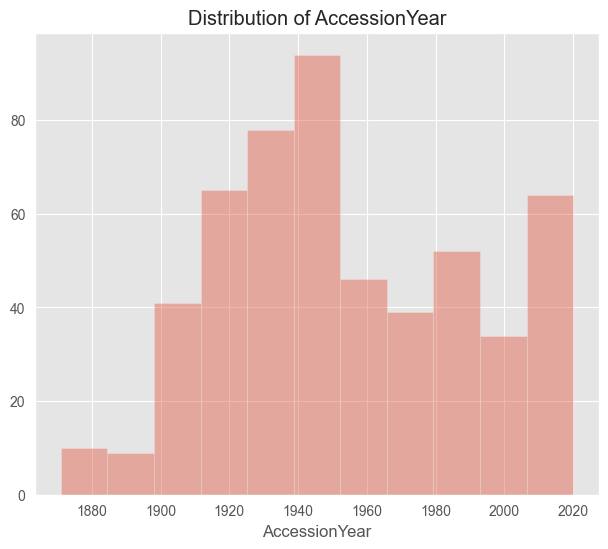

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(ita_data['AccessionYear'], kde=False);
plt.title('Distribution of AccessionYear');
# plt.subplot(1, 2, 2)
# sns.distplot(np.log1p(ita_data['AccessionYear']), kde = False)
# plt.title('Distribution of Log-transformed AccessionYear')

In [5]:
# fig, ax = plt.subplots(figsize=(16, 6))
# plt.subplot(1, 2, 1)
# sns.distplot(ita_data['Medium'], kde=False);
# plt.title('Distribution of End Dates');
# # plt.subplot(1, 2, 2)
# # sns.distplot(np.log1p(ita_data['Medium']), kde = False)
# # plt.title('Distribution of Log-transformed')

#####  DistPlot could not convert string, for example 'Oil on canvas', to float.
#####  Maybe we can create a numerical label list for the column 'Medium'

### Task 5: Distribution of Type of Transfer in Paintings

In [6]:
medium_data = ita_data.loc[ita_data['lastTransfer'].isin(ita_data['lastTransfer'].value_counts().head(10).index)]


Text(0.5, 1.0, 'Mean TransferType of Paintings per Accession Year')

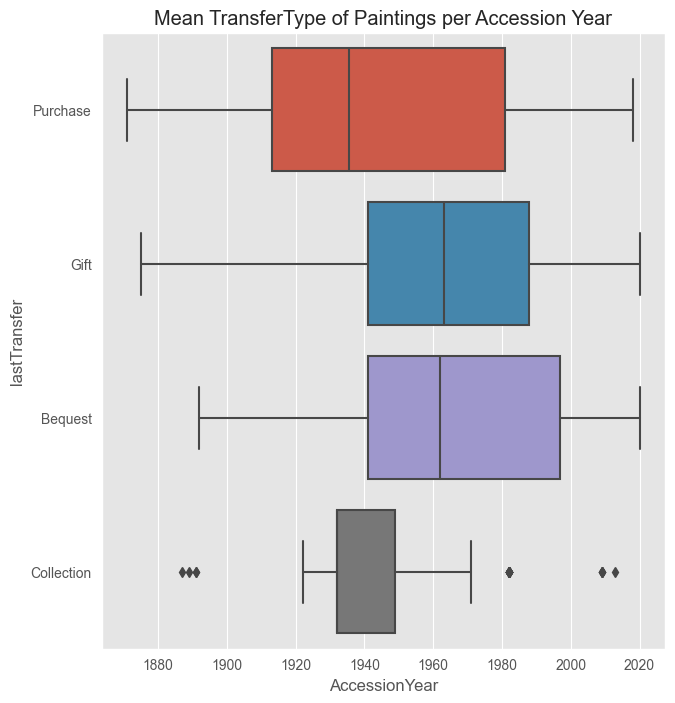

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='AccessionYear', y='lastTransfer', data=medium_data)
plt.title('Mean TransferType of Paintings per Accession Year')

### Task 6: Frequent Titles in Paintings

In [36]:
fav_tags=ita_data.loc[ita_data['lastDealer'].isin(['Rogers Fund',
                                'Gwynne Andrews Fund',
                                'George Blumenthal',
                                'Michael Friedsam',
                                'Theodore M. Davis',
                                'The Jules Bache Collection',
                                'The Jack and Belle Linsky Collection',
                                'J. Pierpont Morgan',
                                'Mrs. Charles Wrightsman',
                                'Maitland F. Griggs',
                                'Grace Rainey Rogers',
                                'Benjamin Altman'])]

In [37]:
# copy_ita_data=ita_data.copy()
fav_tags = fav_tags[fav_tags['Tags'].notnull()]
# tags_list=[]
# for i in range(len(copy_ita_data)):
#     string_it=copy_ita_data.Tags.iloc[i].split('|')
#     string_it=copy_ita_data.Tags.iloc[i].split(' and ')
#     ' '.join(string_it)
#     copy_ita_data.Tags.iloc[i]=' '.join(string_it)

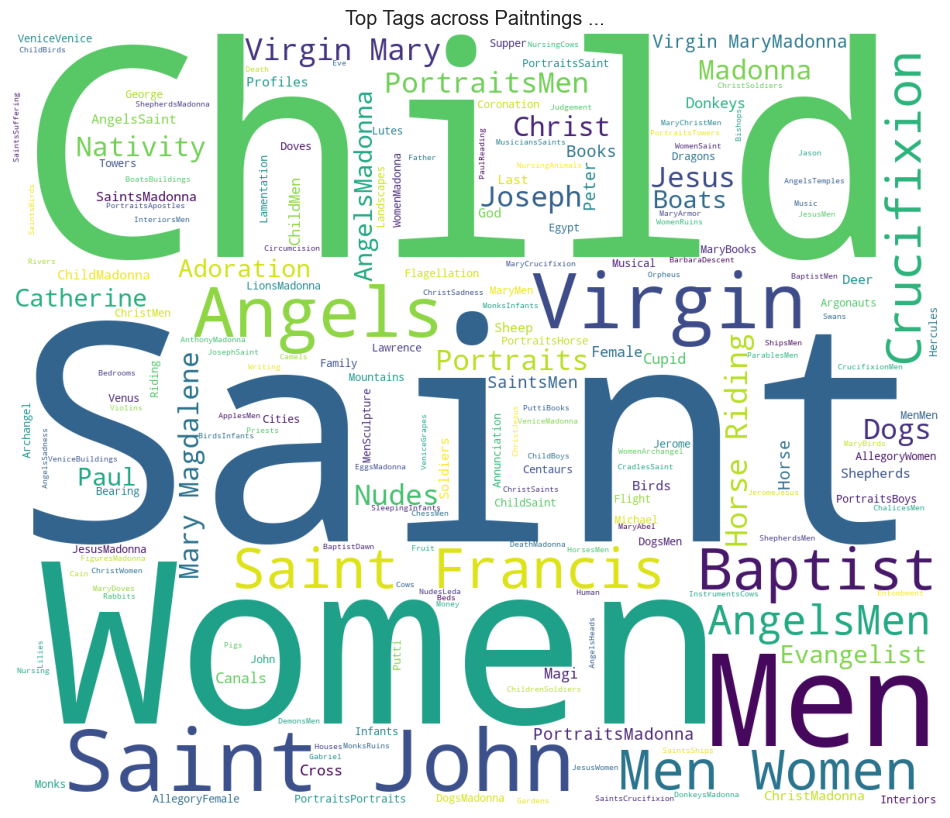

In [38]:
plt.figure(figsize=(12, 12))
text = ''.join(fav_tags['Tags'].values)
wordcloud = WordCloud(max_font_size=None,
                      background_color='white',
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Tags across Paitntings ...')
plt.axis('off')
plt.show()

In [40]:
fav_artist_df=ita_data.loc[ita_data['Artist Display Name'].isin(['Giovanni Battista Tiepolo',
                                                        'Lorenzo Monaco (Piero di Giovanni)',
                                                        'Bernardo Daddi',
                                                        'Giovanni di Paolo (Giovanni di Paolo di Grazia)',
                                                        'Martino di Bartolommeo di Biagio',
                                                        'Titian (Tiziano Vecellio)',
                                                        'Francesco Guardi',
                                                        'Garofalo (Benvenuto Tisi da Garofalo)',
                                                        'Canaletto (Giovanni Antonio Canal)',
                                                        'Simone Martini',
                                                        'Giovanni Battista Tiepolo',
                                                        'Titian (Tiziano Vecellio)'])]

E:\DHDK\datascience-in-dataspell\datascience-in-dataspell\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



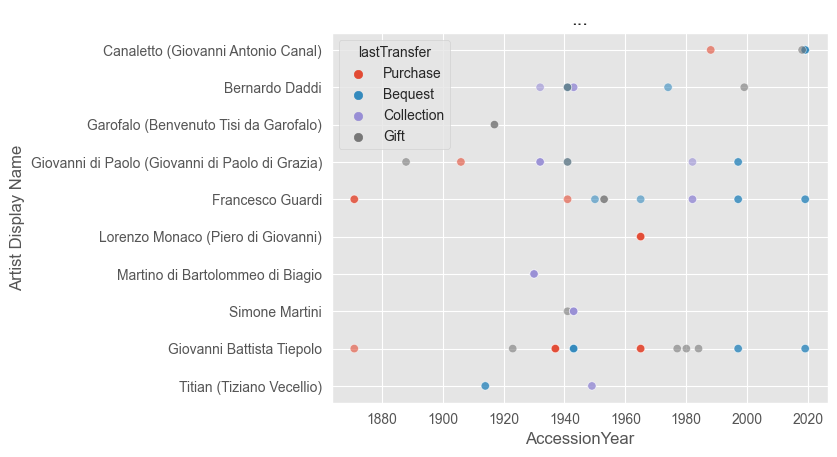

In [41]:

plt.figure()
sns.scatterplot(fav_artist_df['AccessionYear'], fav_artist_df['Artist Display Name'],hue=fav_artist_df['lastTransfer'] ,alpha=0.6)
plt.title("...")
plt.show()

In [47]:
# subset_final = fav_artist_df[['Artist Display Name', 'Object End Date' ,'AccessionYear', 'lastTransfer', 'agentsTransfer']]


##### Label encoding the variables before doing a pairplot because pairplot ignores strings


In [ ]:
# import copy
# from sklearn.preprocessing import LabelEncoder
#
# sub_df_encoded = copy.deepcopy(subset_final)
# sub_df_encoded.loc[:,['Artist Display Name', 'Object End Date' ,'AccessionYear','lastTransfer', 'agentsTransfer']] = sub_df_encoded.loc[:,['Artist Display Name', 'Object End Date' ,'AccessionYear', 'lastTransfer', 'agentsTransfer']].apply(LabelEncoder().fit_transform)
#
# sns.pairplot(sub_df_encoded)  #pairplot
# plt.show()

# Welcome To The Notebook


## TASK 1
Importing modules

In [1]:
import pandas as pd 
import datetime , calendar
import folium

Importing our data

In [2]:
#final_df = pd.read_csv('D:\\PycharmProjects\\infoviz\\data_management\\draftIntegrated.csv')
final_df = pd.read_csv('E:\\GitHub\\infoviz\\data_management\\draftIntegrated.csv')
#final_df.info()

## TASK 2
### Data Preprocessing 
Let's extract starting and ending points  <br>



In [3]:
final_df.receivers.iloc[2].split('; ')

['The Metropolitan Museum of Art',
 'Collezione H.G. Sperling',
 'Kleinberger Galleries',
 'Collezione O. Wertheimer']

In [4]:
final_df.receivers.iloc[0]

'The Metropolitan Museum of Art; Collezione G. Donaldson'

In [5]:
# df_final.shape[0]
for i in range(len(final_df)):
    final_df.receivers.iloc[i]=final_df.receivers.iloc[i].split('; ')

C:\Users\aligh\AppData\Local\Temp\ipykernel_1128\427246154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.receivers.iloc[i]=final_df.receivers.iloc[i].split('; ')


In [6]:
final_df.receivers.iloc[3][-1]

"Asta Christie's"

In [7]:
#ext_starting_point = lambda list_ : list_[0]
#ext_ending_point = lambda list_ : list_[-1]
#final_df["receivers_mid"] = final_df.receivers.apply(ext_starting_point)
#final_df["surrenders_mid"] = final_df.receivers.apply(ext_ending_point)

#final_df.head()

go through each and convert each string to list...

In [8]:
final_df.receivers.iloc[2]

['The Metropolitan Museum of Art',
 'Collezione H.G. Sperling',
 'Kleinberger Galleries',
 'Collezione O. Wertheimer']

In [9]:
#df = pd.DataFrame(columns=['R','S'])

In [10]:
# from itertools import cycle

# i=0
# rec=[]
# sur=[]
# while (i < len(final_df)):
#     # for j in range(len(final_df.receivers.iloc[i])):
#         # print(final_df.receivers.iloc[j])
#         for idx, elem in enumerate(final_df.receivers.iloc[i]):
#             thiselem = elem
#             # df['R'][idx]=thiselem
#             rec.append(thiselem)
#             nextelem = final_df.receivers.iloc[i][(idx + 1) % len(final_df.receivers.iloc[i])]
#             # df['S'][idx]=nextelem
#             sur.append(nextelem)
#             # if len(final_df.receivers.iloc[j]) == 1:
#             #     df['R']=final_df.receivers.iloc[j][k]
#             #     df['S']=final_df.receivers.iloc[j][k]
#             # else: 
#             #     h=0
#             #     while (h < len(final_df.receivers.iloc[j])-1):
#             #         df['R']=final_df.receivers.iloc[j][h]
#             #         df['S']=final_df.receivers.iloc[j][h+1]
#             #         h+=1
                
#         i+=1


In [11]:
# df['R']=rec
# df['S']=sur

In [12]:
# # df2=df.drop_duplicates(keep='first')
# df2 = df.query("R != S")

In [13]:
# df2=df2.reset_index()

In [14]:
# df2=df2[['R','S']].copy()

In [15]:
for i in range(len(final_df)):
    final_df.surrenders.iloc[i]=final_df.surrenders.iloc[i].split('; ')

C:\Users\aligh\AppData\Local\Temp\ipykernel_1128\4081429668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.surrenders.iloc[i]=final_df.surrenders.iloc[i].split('; ')


In [16]:
# i=0
# rec2=[]
# sur2=[]
# while (i < len(final_df)):
#     # for j in range(len(final_df.receivers.iloc[i])):
#         # print(final_df.receivers.iloc[j])
#         for idx, elem in enumerate(final_df.surrenders.iloc[i]):
#             thiselem = elem
#             # df['R'][idx]=thiselem
#             rec2.append(thiselem)
#             nextelem = final_df.surrenders.iloc[i][(idx + 1) % len(final_df.surrenders.iloc[i])]
#             # df['S'][idx]=nextelem
#             sur2.append(nextelem)
#             # if len(final_df.receivers.iloc[j]) == 1:
#             #     df['R']=final_df.receivers.iloc[j][k]
#             #     df['S']=final_df.receivers.iloc[j][k]
#             # else: 
#             #     h=0
#             #     while (h < len(final_df.receivers.iloc[j])-1):
#             #         df['R']=final_df.receivers.iloc[j][h]
#             #         df['S']=final_df.receivers.iloc[j][h+1]
#             #         h+=1
                
#         i+=1



In [17]:
# only_sur=[]
# i=0
# while (i < len(final_df)):
#     for idx, elem in enumerate(final_df.surrenders.iloc[i]):
#         thiselem = elem
#         only_sur.append(elem)
        
#     i+=1

In [18]:
dic_sur=dict()
for index, row in final_df.iterrows():
    for elem in row["surrenders"]:
        if elem not in dic_sur:
            dic_sur[elem]=1
        else:
            dic_sur[elem]=dic_sur[elem]+1
    
    

dic_sur

{"Asta Sotheby's": 3,
 'Ashburnham Place, collezione Ashburnham': 2,
 'Collezione B. Altman': 2,
 'Collezione H.G. Sperling': 2,
 'Kleinberger Galleries': 2,
 'Collezione O. Wertheimer': 1,
 'ChÃ¢teau de Grange Blanche, collezione Chalandon': 1,
 "Asta Christie's": 4,
 'Harewood House, collezione Earl of Harewood': 1,
 'P. Corsini': 2,
 'Collezione S. Brunswick': 1,
 'Hammer Galleries': 1,
 'Chiesa del SS. Nome di GesÃ¹': 1,
 'Collezione J. Pierpont Morgan': 2,
 'Collezioni reali': 1,
 'Collezione Colonna': 1,
 'Convento di S. Antonio da Padova': 1,
 'Collezione G. e F. Blumenthal': 1,
 'Collezione J.H. Harding': 1,
 'Collezione J.E. Taylor': 1,
 'Collezione J.S. Bache': 3,
 'Knoedler and Co.': 1,
 'E. Volpi': 1,
 'Collezione Fassati': 1,
 'Collezione Stillman': 1,
 'Asta Galerie Georges Petit': 2,
 'Collezione B. Crespi': 2,
 'Collezione Linsky': 1,
 'Dowdeswell & Dowdeswell': 1,
 'Collezione colonnello Sacchetti': 1,
 "Oratorio di S. Maria Maddalena all'Isola": 1,
 'Mercato antiquari

In [19]:
dict(sorted(dic_sur.items(), key=lambda item: item[1]))

{'Collezione O. Wertheimer': 1,
 'ChÃ¢teau de Grange Blanche, collezione Chalandon': 1,
 'Harewood House, collezione Earl of Harewood': 1,
 'Collezione S. Brunswick': 1,
 'Hammer Galleries': 1,
 'Chiesa del SS. Nome di GesÃ¹': 1,
 'Collezioni reali': 1,
 'Collezione Colonna': 1,
 'Convento di S. Antonio da Padova': 1,
 'Collezione G. e F. Blumenthal': 1,
 'Collezione J.H. Harding': 1,
 'Collezione J.E. Taylor': 1,
 'Knoedler and Co.': 1,
 'E. Volpi': 1,
 'Collezione Fassati': 1,
 'Collezione Stillman': 1,
 'Collezione Linsky': 1,
 'Dowdeswell & Dowdeswell': 1,
 'Collezione colonnello Sacchetti': 1,
 "Oratorio di S. Maria Maddalena all'Isola": 1,
 'Mercato antiquario': 1,
 'Collezione Mr. e Mrs. C.B. Wrightsman': 1,
 'Collezione Mrs. C. Segal': 1,
 'Morandotti': 1,
 'F. Mont': 1,
 'Galleria Fleischmann': 1,
 'Chatsworth House, collezione duca del Devonshire': 1,
 'Collezione Friedsam': 1,
 'Collezione Dillon': 1,
 "Collezione Chaix-d'Est Anges": 1,
 'Collezione R. Lehman': 1,
 "Agnew's"

df_sur = pd.DataFrame(columns=['R','S'])
df_sur['R']=rec2
df_sur['S']=sur2
df_sur = df_sur.query("R != S")
df4=df4.drop_duplicates(keep='first')
df_sur=df_sur.reset_index()
df_sur=df_sur[['R','S']].copy()

df_sur_rec=pd.concat([df2, df_sur])

In [20]:
dict_df=pd.DataFrame([dic_sur])
dict_df=dict_df.T
dict_df=dict_df.sort_values(0, ascending=False)
dict_df.head()

,0
Asta Christie's,4
Asta Sotheby's,3
"Duveen Brothers, Inc.",3
Collezione J.S. Bache,3
Kleinberger Galleries,2


In [21]:
#dict_df.drop(dict_df[dict_df > 2 ].index, inplace=True)

In [22]:
dict_df.rename(columns={0:'freq'}, inplace=True)

we are considering threshold more than 1 as hub in dataset

In [23]:
dict_df_freq=dict_df.query('freq > 1')

In [24]:
# dict_df_freq.plot.bar(grid=True)

In [25]:
dict_df_freq

,freq
Asta Christie's,4
Asta Sotheby's,3
"Duveen Brothers, Inc.",3
Collezione J.S. Bache,3
Kleinberger Galleries,2
Collezione H.G. Sperling,2
Collezione B. Altman,2
"Ashburnham Place, collezione Ashburnham",2
Collezione B. Crespi,2
Asta Galerie Georges Petit,2


In [26]:
freq_lst=[]
freq_val=[]
for elem in dic_sur:
    if dic_sur[elem]>1:
        freq_lst.append(elem)
        freq_val.append(dic_sur[elem])

In [27]:
freq_lst

["Asta Sotheby's",
 'Ashburnham Place, collezione Ashburnham',
 'Collezione B. Altman',
 'Collezione H.G. Sperling',
 'Kleinberger Galleries',
 "Asta Christie's",
 'P. Corsini',
 'Collezione J. Pierpont Morgan',
 'Collezione J.S. Bache',
 'Asta Galerie Georges Petit',
 'Collezione B. Crespi',
 'Duveen Brothers, Inc.']

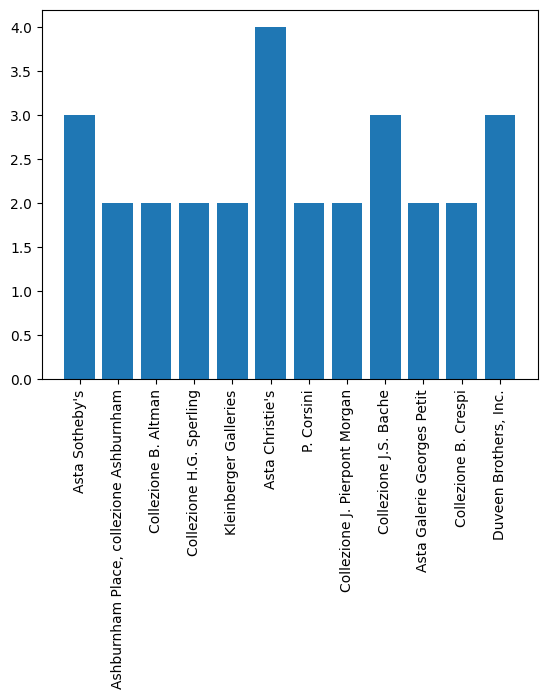

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['tab:blue']

ax.bar(freq_lst, freq_val, color=bar_colors)

ax.set_ylabel('')
ax.set_title('')
#ax.legend(title='')
plt.xticks(rotation=90)
plt.show()

In [29]:
# df_sur_rec.duplicated().any()

In [30]:
# df5=df5.drop_duplicates(keep='first')

In [31]:
#df_sur_rec_final=df_sur_rec.reset_index()
#df_sur_rec_final=df_sur_rec_final[['R','S']].copy()

In [32]:
#df_sur_rec_final

In [34]:
#art_dealers_dict={artdealer1:{artist1:1, artist2:2}, artdealer2:{.. . ..}}

#agents_df=pd.read_csv("D:\\PycharmProjects\\infoviz\\data_management\\transfers.csv")
agents_df=pd.read_csv("E:\\GitHub\\infoviz\\data_management\\transfers.csv")


art_dealers_dict={}

for index, row in agents_df.iterrows():
    if type(row["agentsTransfer"]) == type(""):
        for elem in row["agentsTransfer"].split(', '):
            if elem not in art_dealers_dict:
                art_dealers_dict[elem]={row["Artist Display Name"]:1}
            else:
                if row["Artist Display Name"] in art_dealers_dict[elem]:
                    art_dealers_dict[elem][row["Artist Display Name"]]+=1
                else:
                    art_dealers_dict[elem][row["Artist Display Name"]]=1

art_dealers_dict

{'Rudolph and Lentilhon G. von Fluegge Foundation Inc.': {'Jacopo Amigoni': 1},
 'Rogers Fund': {'Andrea di Bartolo': 1,
  'Zanobi Strozzi': 1,
  'Antoniazzo Romano (Antonio di Benedetto Aquilio)': 1,
  'Giovanni Baronzio': 1,
  'Fra Bartolomeo (Bartolomeo di Paolo del Fattorino)': 1,
  'Pompeo Batoni': 2,
  'Giovanni Bellini': 1,
  'Francesco Botticini (Francesco di Giovanni)': 1,
  'Bronzino': 1,
  'Caravaggio (Michelangelo Merisi)': 1,
  'Fra Carnevale (Bartolomeo di Giovanni Corradini)': 1,
  'Rosalba Carriera': 1,
  'Bernardo Cavallino': 1,
  'Cima da Conegliano (Giovanni Battista Cima)': 1,
  'Giovanni di Bartolommeo Cristiani': 1,
  'Carlo Crivelli': 2,
  'Gaspare Diziani': 1,
  'Defendente Ferrari': 1,
  'Domenico Fetti': 2,
  'Bernardino Fungai': 1,
  'Taddeo Gaddi': 1,
  'Michele Giambono (Michele Giovanni Bono)': 1,
  'Giovanni da Milano': 1,
  'Giovanni di Paolo (Giovanni di Paolo di Grazia)': 1,
  'Giovanni di ser Giovanni Guidi (called Scheggia)': 1,
  'Benozzo Gozzoli (B

In [35]:
for elem in art_dealers_dict:

    art_dealers_dict[elem] = dict(sorted(art_dealers_dict[elem].items(), key=lambda item: item[1]))

In [36]:
art_dealers_dict

{'Rudolph and Lentilhon G. von Fluegge Foundation Inc.': {'Jacopo Amigoni': 1},
 'Rogers Fund': {'Andrea di Bartolo': 1,
  'Zanobi Strozzi': 1,
  'Antoniazzo Romano (Antonio di Benedetto Aquilio)': 1,
  'Giovanni Baronzio': 1,
  'Fra Bartolomeo (Bartolomeo di Paolo del Fattorino)': 1,
  'Giovanni Bellini': 1,
  'Francesco Botticini (Francesco di Giovanni)': 1,
  'Bronzino': 1,
  'Caravaggio (Michelangelo Merisi)': 1,
  'Fra Carnevale (Bartolomeo di Giovanni Corradini)': 1,
  'Rosalba Carriera': 1,
  'Bernardo Cavallino': 1,
  'Cima da Conegliano (Giovanni Battista Cima)': 1,
  'Giovanni di Bartolommeo Cristiani': 1,
  'Gaspare Diziani': 1,
  'Defendente Ferrari': 1,
  'Bernardino Fungai': 1,
  'Taddeo Gaddi': 1,
  'Michele Giambono (Michele Giovanni Bono)': 1,
  'Giovanni da Milano': 1,
  'Giovanni di Paolo (Giovanni di Paolo di Grazia)': 1,
  'Giovanni di ser Giovanni Guidi (called Scheggia)': 1,
  'Francesco Granacci (Francesco di Andrea di Marco)': 1,
  'Francesco Granacci': 1,
  'F

In [37]:
for key in art_dealers_dict:
    art_dealers_dict[key]=list(art_dealers_dict[key])[-1]
art_dealers_dict

{'Rudolph and Lentilhon G. von Fluegge Foundation Inc.': 'Jacopo Amigoni',
 'Rogers Fund': 'Giovanni Battista Tiepolo',
 'Helen O. Brice': 'Giacomo Andreoli',
 'Lucy G. Moses': 'Taddeo di Bartolo',
 'Benjamin Altman': 'Titian (Tiziano Vecellio)',
 'May Dougherty King': 'Zanobi Strozzi',
 'The Friedsam Collection': 'Giovanni di Paolo (Giovanni di Paolo di Grazia)',
 'Michael Friedsam': 'Giovanni di Paolo (Giovanni di Paolo di Grazia)',
 'George Blumenthal': 'Bernardo Daddi',
 'Gwynne Andrews Fund': 'Lorenzo Monaco (Piero di Giovanni)',
 'The Jack and Belle Linsky Collection': 'Francesco Guardi',
 'Samuel H. Kress Foundation': 'Antonio Vivarini',
 'Michael Dreicer': 'Pietro di Francesco Orioli',
 'Fletcher Fund': 'Bergognone (Ambrogio di Stefano da Fossano)',
 'Daniel Wildenstein': 'Bartolomeo di Giovanni',
 'The Charles Engelhard Foundation': 'Pompeo Batoni',
 'Robert Lehman Foundation Inc.': 'Pompeo Batoni',
 'Mrs. Haebler Frantz': 'Pompeo Batoni',
 'April R. Axton': 'Pompeo Batoni',
 

In [38]:
artdealers_df=pd.DataFrame([art_dealers_dict])
artdealers_df=artdealers_df.T
artdealers_df

,0
Rudolph and Lentilhon G. von Fluegge Foundation Inc.,Jacopo Amigoni
Rogers Fund,Giovanni Battista Tiepolo
Helen O. Brice,Giacomo Andreoli
Lucy G. Moses,Taddeo di Bartolo
Benjamin Altman,Titian (Tiziano Vecellio)
...,...
Lillian S. Timken,Stefano da Verona (Stefano di Giovanni d'Arbos...
Forsyth Wickes,Stefano da Verona (Stefano di Giovanni d'Arbos...
the Eugene V. and Clare E. Thaw Charitable Trust,Canaletto (Giovanni Antonio Canal)
Errol M. Rudman,Orsola Maddalena Caccia


In [39]:
artdealers_df=pd.DataFrame(art_dealers_dict, index=['Artist',])

In [40]:
artdealers_df["Rogers Fund"]

Artist    Giovanni Battista Tiepolo
Name: Rogers Fund, dtype: object

In [42]:
#metdealer=pd.read_csv("D:\\PycharmProjects\\infoviz\\assets\\dataForSite\\exportCsv\\metdealer.csv")
metdealer=pd.read_csv("E:\\GitHub\\infoviz\\assets\\dataForSite\\exportCsv\\metdealer.csv")

metdealer=metdealer[~metdealer['dealer'].isnull()]
metdealer_freq=metdealer.query('freq > 11')
metdealer_freq=metdealer_freq.sort_values('freq',ascending=False)
#for index, row in metdealer.iterrows():
metdealer_freqlst=metdealer_freq['dealer'].tolist()
metdealer_freqlst

['Rogers Fund',
 'Gwynne Andrews Fund',
 'George Blumenthal',
 'Michael Friedsam',
 'Theodore M. Davis',
 'The Jules Bache Collection',
 'The Jack and Belle Linsky Collection',
 'J. Pierpont Morgan',
 'Mrs. Charles Wrightsman',
 'Maitland F. Griggs',
 'Grace Rainey Rogers',
 'Benjamin Altman']

In [43]:
favartist_lst=[]
for elem in metdealer_freqlst:
    templst=artdealers_df[elem].to_list()
    favartist_lst.append(templst[0])
favartist_lst

['Giovanni Battista Tiepolo',
 'Lorenzo Monaco (Piero di Giovanni)',
 'Bernardo Daddi',
 'Giovanni di Paolo (Giovanni di Paolo di Grazia)',
 'Martino di Bartolommeo di Biagio',
 'Titian (Tiziano Vecellio)',
 'Francesco Guardi',
 'Garofalo (Benvenuto Tisi da Garofalo)',
 'Canaletto (Giovanni Antonio Canal)',
 'Simone Martini',
 'Giovanni Battista Tiepolo',
 'Titian (Tiziano Vecellio)']

In [44]:
import nltk
import spacy
 
# essential entity models downloads
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('treebank')
nltk.downloader.download('maxent_treebank_pos_tagger')
nltk.downloader.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aligh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_p

True

In [46]:
import locationtagger

# initializing sample text
sample_text = "Italian, Venice 1682 1752 Madrid"
 
# extracting entities.
place_entity = locationtagger.find_locations(text = sample_text)
 
# # getting all countries
# print("The countries in text : ")
# print(place_entity.countries)
 
# # getting all states
# print("The states in text : ")
# print(place_entity.regions)
 
# getting all cities
print("The cities in text : ")
print(place_entity.cities)

The cities in text : 
['Venice', 'Madrid']


In [47]:
agents_df['Artist Display Bio'][0]

'Italian, Venice 1682–1752 Madrid'

In [48]:
agents_df.loc[agents_df['Artist Display Name'] == 'Giovanni Battista Tiepolo', 'Artist Display Bio'].iloc[0]

'Italian, Venice 1696–1770 Madrid'

In [49]:
favartist_loclist=[]
for elem in favartist_lst:
    favartist_loclist.append(agents_df.loc[agents_df['Artist Display Name'] == elem, 'Artist Display Bio'].iloc[0])

favartist_loclist

['Italian, Venice 1696–1770 Madrid',
 'Italian, Florence (?) ca. 1370–1425 Florence (?)',
 'Italian, Florence (?) ca. 1290–1348 Florence',
 'Italian, Siena 1398–1482 Siena',
 'Italian, Sienese, active by 1389–died 1434/35',
 'Italian, Pieve di Cadore ca. 1485/90?–1576 Venice',
 'Italian, Venice 1712–1793 Venice',
 'Italian, Ferrara 1481–1559 Ferrara',
 'Italian, Venice 1697–1768 Venice',
 'Italian, Siena, active by 1315–died 1344 Avignon',
 'Italian, Venice 1696–1770 Madrid',
 'Italian, Pieve di Cadore ca. 1485/90?–1576 Venice']

ghg

In [62]:
dict_favartist_loc=dict()

def make_dict(keys, values):
    return dict(zip(keys, values))

dict_favartist_loc=make_dict(favartist_lst, favartist_loclist)
dict_favartist_loc

{'Giovanni Battista Tiepolo': 'Italian, Venice 1696–1770 Madrid',
 'Lorenzo Monaco (Piero di Giovanni)': 'Italian, Florence (?) ca. 1370–1425 Florence (?)',
 'Bernardo Daddi': 'Italian, Florence (?) ca. 1290–1348 Florence',
 'Giovanni di Paolo (Giovanni di Paolo di Grazia)': 'Italian, Siena 1398–1482 Siena',
 'Martino di Bartolommeo di Biagio': 'Italian, Sienese, active by 1389–died 1434/35',
 'Titian (Tiziano Vecellio)': 'Italian, Pieve di Cadore ca. 1485/90?–1576 Venice',
 'Francesco Guardi': 'Italian, Venice 1712–1793 Venice',
 'Garofalo (Benvenuto Tisi da Garofalo)': 'Italian, Ferrara 1481–1559 Ferrara',
 'Canaletto (Giovanni Antonio Canal)': 'Italian, Venice 1697–1768 Venice',
 'Simone Martini': 'Italian, Siena, active by 1315–died 1344 Avignon'}

In [65]:
favartist_cities=[]
for elem in favartist_loclist:

    # extracting entities.
    place_entity = locationtagger.find_locations(text = elem)

    if len(place_entity.cities) == 0:
        favartist_cities.append('0')
    else:
        favartist_cities.append(place_entity.cities[0])

# # getting all countries
# print("The countries in text : ")
# print(place_entity.countries)

# # getting all states
# print("The states in text : ")
# print(place_entity.regions)

# getting all cities
print(favartist_cities)

['Venice', 'Florence', 'Florence', '0', '0', 'Venice', 'Venice', '0', 'Venice', 'Avignon', 'Venice', 'Venice']


In [71]:
# a = metdealer_freqlst
# b = favartist_lst
# c = favartist_loclist

dict_fav_artists_for_metdealers = dict(map(lambda x, y, z : (x, {str(y): str(z)}), metdealer_freqlst, favartist_lst, favartist_loclist))

print(dict_fav_artists_for_metdealers)

{'Rogers Fund': {'Giovanni Battista Tiepolo': 'Italian, Venice 1696–1770 Madrid'}, 'Gwynne Andrews Fund': {'Lorenzo Monaco (Piero di Giovanni)': 'Italian, Florence (?) ca. 1370–1425 Florence (?)'}, 'George Blumenthal': {'Bernardo Daddi': 'Italian, Florence (?) ca. 1290–1348 Florence'}, 'Michael Friedsam': {'Giovanni di Paolo (Giovanni di Paolo di Grazia)': 'Italian, Siena 1398–1482 Siena'}, 'Theodore M. Davis': {'Martino di Bartolommeo di Biagio': 'Italian, Sienese, active by 1389–died 1434/35'}, 'The Jules Bache Collection': {'Titian (Tiziano Vecellio)': 'Italian, Pieve di Cadore ca. 1485/90?–1576 Venice'}, 'The Jack and Belle Linsky Collection': {'Francesco Guardi': 'Italian, Venice 1712–1793 Venice'}, 'J. Pierpont Morgan': {'Garofalo (Benvenuto Tisi da Garofalo)': 'Italian, Ferrara 1481–1559 Ferrara'}, 'Mrs. Charles Wrightsman': {'Canaletto (Giovanni Antonio Canal)': 'Italian, Venice 1697–1768 Venice'}, 'Maitland F. Griggs': {'Simone Martini': 'Italian, Siena, active by 1315–died 13

In [73]:
favartist_cities[3] = 'Siena'
favartist_cities[4] = 'Siena'
favartist_cities[7] = 'Ferrara'
favartist_cities[9] = 'Siena'
favartist_cities

['Venice',
 'Florence',
 'Florence',
 'Siena',
 'Siena',
 'Venice',
 'Venice',
 'Ferrara',
 'Venice',
 'Siena',
 'Venice',
 'Venice']

In [74]:
dict_fav_artists_for_metdealers = dict(map(lambda x, y, z : (x, {str(y): str(z)}), metdealer_freqlst, favartist_lst, favartist_cities))

print(dict_fav_artists_for_metdealers)

{'Rogers Fund': {'Giovanni Battista Tiepolo': 'Venice'}, 'Gwynne Andrews Fund': {'Lorenzo Monaco (Piero di Giovanni)': 'Florence'}, 'George Blumenthal': {'Bernardo Daddi': 'Florence'}, 'Michael Friedsam': {'Giovanni di Paolo (Giovanni di Paolo di Grazia)': 'Siena'}, 'Theodore M. Davis': {'Martino di Bartolommeo di Biagio': 'Siena'}, 'The Jules Bache Collection': {'Titian (Tiziano Vecellio)': 'Venice'}, 'The Jack and Belle Linsky Collection': {'Francesco Guardi': 'Venice'}, 'J. Pierpont Morgan': {'Garofalo (Benvenuto Tisi da Garofalo)': 'Ferrara'}, 'Mrs. Charles Wrightsman': {'Canaletto (Giovanni Antonio Canal)': 'Venice'}, 'Maitland F. Griggs': {'Simone Martini': 'Siena'}, 'Grace Rainey Rogers': {'Giovanni Battista Tiepolo': 'Venice'}, 'Benjamin Altman': {'Titian (Tiziano Vecellio)': 'Venice'}}


In [116]:
# importing geopy library
from geopy.geocoders import Nominatim

# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")
lat=[]
long=[]
# entering the location name
for elem in favartist_cities:
    getLoc = loc.geocode(elem)
    lat.append(getLoc.latitude)
    long.append(getLoc.longitude)

In [117]:
cord_list=list(zip(lat, long))

In [118]:
# Map = folium.Map(location = [45.43,12.33], zoom_start=1)
# for point in cord_list:
#     folium.CircleMarker(location=point, color="red", radius=5, weight=5).add_to(Map)
# Map

In [119]:
df_cord = pd.DataFrame(columns = ["Lat", "Long"])
df_cord["Lat"]=lat
df_cord["Long"]=long

In [120]:
m = folium.Map(df_cord[['Lat', 'Long']].mean().values.tolist())

for lat, lon in zip(df_cord['Lat'], df_cord['Long']):
    folium.Marker([lat, lon]).add_to(m)

sw = df_cord[['Lat', 'Long']].min().values.tolist()
ne = df_cord[['Lat', 'Long']].max().values.tolist()

m.fit_bounds([sw, ne])
m

In [75]:
# favartist_cities=[]
# for elem in favartist_loclist:
#
#     # extracting entities.
#     place_entity = locationtagger.find_locations(text = elem)
#
#     if len(place_entity.cities) == 0:
#         favartist_cities.append('0')
#     else:
#         favartist_cities.append(place_entity.cities[0])

In [ ]:
# sample_text = "Italian, Venice 1682 1752 Madrid"

# # extracting entities.
# place_entity1 = locationtagger.find_locations(text = sample_text)

# # # getting all countries
# # print("The countries in text : ")
# # print(place_entity.countries)

# # # getting all states
# # print("The states in text : ")
# # print(place_entity.regions)

# # getting all cities
# print("The cities in text : ")
# print(place_entity1.cities)

In [ ]:
# place_entity1.cities[0]